In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd

sys.path.append('../lib')
from storage import get_storage_functions, quantize
from local_paths import preproc_dir, analysis_dir, database_dir
from self_consistency import \
    find_return_fixations, pairwise_self_consistency, \
    pairwise_self_consistency_perm_test

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_win = 200


#============================================================================
# fixation/saccade selection
#============================================================================
# fixation criteria
ifix_sel = 2  # 0 = zeroth-fix only; 1 = non-zeroth-fix only; otherwise = both


#============================================================================
# return fixation selection
#============================================================================
return_thres = 1  # for defining "return fixation"; can set to typical radius of rf


#============================================================================
# statistical tests
#============================================================================
stat_tests      = (('current', 'same_image', 'greater'),)
n_perm          = 10000
save_perm_diffs = False  # whether to save permuted delta effect sizes


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
latency_path = database_dir + 'per_unit_latency-fix_on.csv.gz'
output_dir = analysis_dir + 'rsc_1pt'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
print('Loading rasters from', rasters_path)
rasters_path = rasters_path.expanduser()
assert rasters_path.is_file()

print('Using per-unit latency from', latency_path)
latency_path = Path(latency_path).expanduser()
assert latency_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading rasters from ../test_data/Pa210201-rasters.nwb
Using per-unit latency from ../db/per_unit_latency-fix_on.csv.gz
Saving results to ../test_results/Pa210201.h5


In [5]:
analysis_name = 'rsc_1pt'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

# Save config

In [6]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    unit_names = f['unit_selection/simple'][()].astype(str)
    fix_sel = f['fixation_selection/fixation_indices'][()]
    if ifix_sel in (0, 1):
        m = 0 == fix_df.index.get_level_values(fix_df.index.names.index('Fixation'))[fix_sel]
        if ifix_sel == 1:
            m = ~m
        fix_sel = fix_sel[m]

print('random_seed:', random_seed)

random_seed: 775418045


In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)
save_results(group+'ifix_sel', ifix_sel)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_win', t_win)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/return_criterion/'
save_results(group+'return_thres', return_thres, attrs=dict(unit='dva'))

group = analysis_name + '/config/statistics/'
save_results(group+'tests', str(stat_tests))
save_results(group+'test_kind', 'permutation')
save_results(group+'n_perm', n_perm)

save_results(analysis_name+'/fixation_selection', fix_sel)
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))

# Find return pairs

In [9]:
df_ = fix_df.iloc[fix_sel]
imids = np.array([f'{v0}/{v1}' for v0, v1 in df_[['Image subdir', 'Image filename']].values])
posns = df_[['Relative X', 'Relative Y']].values

curr_return_pairs = find_return_fixations(imids, posns, thres_deg=return_thres)
same_image_return_pairs = find_return_fixations(imids, np.zeros_like(posns), thres_deg=return_thres)
print('"current" return pairs shape:', curr_return_pairs.shape)
print('"same_image" return pairs shape:', same_image_return_pairs.shape)

bycond_return_pairs = dict(
    current=curr_return_pairs,
    same_image=same_image_return_pairs)

"current" return pairs shape: (2325, 2)
"same_image" return pairs shape: (27492, 2)


In [10]:
group = analysis_name + '/return_pairs/'
for cond, pairs in bycond_return_pairs.items():
    if not pairs.size:
        pairs = h5.Empty('i')
    save_results(group+cond, pairs)

# Get fixation onset-aligned responses uaing latency per unit

In [11]:
with h5.File(rasters_path, 'r') as f:
    all_unit_names = f['processing/ecephys/unit_names/unit_name'][()].astype(str)
    all_unit_names = list(all_unit_names)
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    rasters = f['processing/ecephys/rasters/data'][()][:,sel_]

In [12]:
lat_df = pd.read_csv(latency_path).set_index('Session').loc[[sess_name]].set_index('Name')
m = pd.Series(unit_names).isin(lat_df.index)
assert m.all(), f'missing latency value for {(~m).sum()} of {m.size} units'
assert not lat_df.index.has_duplicates

lat_df = lat_df.loc[unit_names].reset_index()
assert len(lat_df) == len(unit_names)
lat_df['Index'] = np.arange(len(lat_df))
lat_df['Latency'] = np.clip(lat_df['Latency'], 40, None)
print('Num units using RF fit from each source:')
print('\t' + '\n\t'.join(str(lat_df.groupby('Source').count()['Latency']).split('\n')[:-1]))

Num units using RF fit from each source:
	Source
	Array                 29
	Array, across sess    40
	Channel               11
	Unit                  12


In [13]:
resps = np.empty((fix_sel.size, rasters.shape[1]), dtype=np.float32)
t_win_ = np.array([0, t_win])
lat_groups = [(dt, df_['Index'].values) for dt, df_ in lat_df.groupby('Latency')]
for i, t in enumerate(fix_df.iloc[fix_sel]['Time'].values):
    for dt, usel in lat_groups:
        s = slice(*np.round(t+dt+t_win_).astype(int))
        resps[i,usel] = rasters[s,usel].mean(0)
del rasters
resps.shape, resps.dtype

((5979, 92), dtype('float32'))

In [14]:
lat_df.to_hdf(output_path, analysis_name+'/latency_per_unit', mode='a', format='table', complevel=9, complib='zlib')

# One-condition permutation test

In [15]:
coords = (('unit', unit_names),)
attrs = dict(
    return_thres=return_thres,
    random_seed=random_seed,
    unit='Pearson\'s r')

bycond_rsc_ds = {}
cond = 'current'
pairs = bycond_return_pairs[cond]
if len(pairs) > 1:
    attrs['n_pairs'] = len(pairs)
    ds = pairwise_self_consistency(
        pairs=pairs, resps=resps,
        n_bootstraps=0, n_permutations=n_perm,
        random_seed=random_seed,
        coords=coords, attrs=attrs)
else:
    ds = None
bycond_rsc_ds[cond] = ds

In [16]:
group = analysis_name + '/'
q = lambda x: quantize(x, 3)
compr = dict(zlib=True, complevel=9)
for cond, dataset in bycond_rsc_ds.items():
    loc = group + cond
    if dataset is not None:
        if not save_perm_diffs:
            dataset = dataset.drop_vars('permutations')
        k = 'sample'
        dataset = dataset.assign({k: q(dataset.data_vars[k])})
        encoding = {
            k: dict(chunksizes=v.shape, **compr)
            for k, v in dataset.data_vars.items()
            if v.size}
        dataset.to_netcdf(
            output_path, group=loc, mode='a',
            engine='h5netcdf', encoding=encoding)
    else:
        save_results(loc, h5.Empty('f'))

# Two-condition permutation test

In [17]:
test_results = {}

coords = (('unit', unit_names),)
attrs = dict(random_seed=random_seed)

for test in stat_tests:
    c0, c1 = test[:2]
    if len(test) > 2:
        alt = test[2]
    else:
        alt = 'two-sided'
    print('test:', (c0, c1), '\talternative:', alt)

    try:
        ds = pairwise_self_consistency_perm_test(
            resps=resps,
            pairs0=bycond_return_pairs[c0],
            pairs1=bycond_return_pairs[c1],
            alternatives=alt,
            n_permutations=n_perm,
            random_seed=random_seed,
            coords=coords,
            attrs=attrs,
            verbose=True)
    except ValueError as e:
        if 'Less than 2 pairs' in str(e):
            continue
        raise

    test_results[(c0,c1)] = ds

test: ('current', 'same_image') 	alternative: greater
calculating self consistency permutation distribution w.r.t. pairing conditions
10000 permutations
	using 20000 (2325+17675) pairs of 29817 (2325+27492)


done (98.7 s)


In [18]:
group = analysis_name + '/permutation_test/'
compr = dict(zlib=True, complevel=9)
for (c0, c1), dataset in test_results.items():
    if not save_perm_diffs:
        dataset = dataset.drop_vars('permuted_diffs')
    encoding = {
        k: dict(chunksizes=v.shape, **compr)
        for k, v in dataset.data_vars.items()
        if v.size}
    dataset.to_netcdf(
        output_path, group=group+f'{c0}_v_{c1}',
        mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [19]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [20]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:15:31.013940-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

h5py  : 3.8.0
pandas: 2.0.1
numpy : 1.24.3
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]



# Plots

In [21]:
import matplotlib.pyplot as plt

f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
p_thres = .01

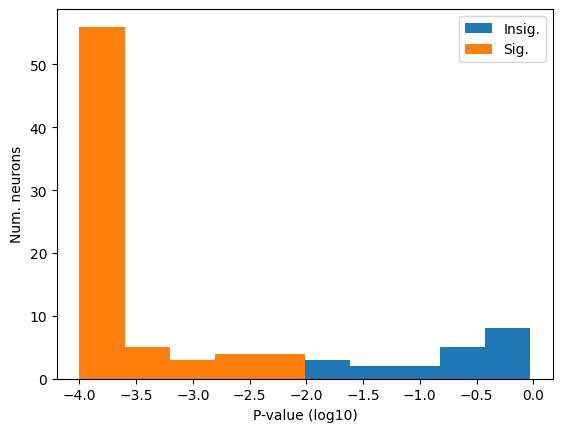

In [22]:
if n_perm > 0:
    cond = 'current'
    dataset = bycond_rsc_ds[cond]
    plt.figure()
    x = dataset['p-value'].values.ravel()
    sig = x < p_thres
    plt.hist([np.log10(x[~sig]), np.log10(x[sig])], stacked=True, label=['Insig.','Sig.'])
    plt.xlabel('P-value (log10)')
    plt.ylabel('Num. neurons')
    plt.legend()
else:
    sig = np.zeros(unit_names.size, dtype=bool)

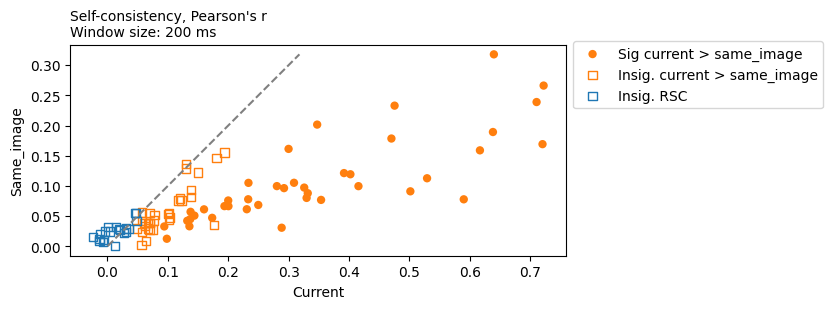

In [23]:
for test, results in test_results.items():
    plt.figure()
    vals = np.array([results['cond0'], results['cond1']])
    if n_perm > 0:
        sig_ = results['p-value'].values.ravel() < p_thres
    else:
        sig_ = np.zeros(unit_names.size, dtype=bool)
    for i in range(2):
        for j in range(2):
            m = (sig^bool(i))&(sig_^bool(j))
            if not m.any(): continue
            c = ('tab:orange', 'tab:blue')[i]
            if j:
                kwargs = dict(ec=c, fc='none', marker='s')
            else:
                kwargs = dict(fc=c, ec='none', marker='o')
            if i:
                kwargs['label'] = 'Insig. RSC'
            else:
                kwargs['label'] = ('Sig', 'Insig.')[j] + ' '+ ' > '.join(test[:2])
            plt.scatter(*vals[:,m], **kwargs)
    b = np.ma.masked_invalid(vals)
    b = [b.min(1).max(0), b.max(1).min(0)]
    plt.plot(b, b, color='gray', ls='--')
    plt.xlabel(test[0].capitalize())
    plt.ylabel(test[1].capitalize())
    plt.text(0, 1.025, f'Self-consistency, Pearson\'s r\nWindow size: {t_win} ms',
              ha='left', va='bottom', transform=plt.gca().transAxes)
    plt.gca().set_aspect('equal')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1.05))